# Causal Effect Inference

We are in the context of an **observational study**: we observe outcomes ($Y$) for available subjects (with many characteristics $X_i$) on the variables of interest ($T$) without control over this variable. This setting poses a problem: there may be lurking variables not taken into account who affect both the treatment and the outcome (i.e., confounders) making the establishment of cause and effect much harder.

This stands in contrast to Randomized Clinical Trials (RCTs), where instead we can randomize the assignment of the subjects to the values of the variable of interest so that no confounders are present.

**Causal Graphical Model (Causal Bayesian Network)**

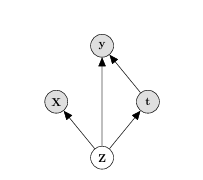

We **observe** the features $X_i$, the treatment $T$ and the outcome $Y$, but we do **not observe** the hidden confounder $Z$!

Our **objective** is to estimate the **Average Treatment Effect** (ATE), i.e., the effect of $T$ on $Y$.

In [1]:
from data_gen import synthetic_dataset_pyro, synthetic_dataset_linear
from dowhy import CausalModel
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import pyro
from pyro.contrib.cevae import CEVAE
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import logging
import itertools


logging.getLogger("pyro").setLevel(logging.DEBUG)
logging.getLogger("pyro").handlers[0].setLevel(logging.DEBUG)

/home/giovanni/Desktop/pml_project/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = synthetic_dataset_pyro(n=2000, beta=2.0, num_proxies=10,prior_type = "gaussian", seed=42)
data.keys()
length_x = len(data["x"][1]) 

#clone
data_original = data.copy()

In [3]:
# translating the dictionary in a dataframe
# I need to change the x matrix in different x columns
for i in range(data["x"].shape[1]):
    data["x_"+str(i)] = data["x"][:,i]

data.pop("x",None)

data_df = pd.DataFrame.from_dict(data)
data_df.head()

,t,y,z,ite,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9
0,1.0,3.374198,1.926915,1.963458,-0.688857,-1.794350,0.164417,-1.106328,0.477889,-0.949815,-1.100642,-0.573700,1.335683,-0.812672
1,0.0,0.389723,1.487284,1.743642,-0.803419,-0.667056,-0.221031,-0.335255,-2.074355,-0.946630,-0.484487,0.730178,-0.984199,0.626180
2,1.0,2.342756,0.900717,1.450359,-0.960594,0.498550,-0.208753,0.067716,0.217839,-0.090666,0.945358,0.879692,-1.900329,-1.909228
3,0.0,-3.112403,-2.105521,-0.052760,0.131827,1.523604,-1.069372,0.534380,-0.513794,2.163477,0.522745,-2.856230,-0.540974,0.486115
4,1.0,2.221629,0.678418,1.339209,0.114251,-1.388160,-0.912516,0.000940,1.237285,-0.903159,-1.597616,-1.240581,0.409051,-0.279541


We can obtain a naive estimate for the ATE by taking the mean of the outcome in the two groups in the dataset (those that received the treatment and those who didn't). We call this estimate "unadgusted" because we are not considering any of the covariates that can affect the treatment effect.

In [4]:
data_1 = data_df[data_df["t"]==1.0]
data_0 = data_df[data_df["t"]==0.0]

print("Unadjusted ATE", np.mean(data_1["y"])- np.mean(data_0["y"]))

Unadjusted ATE 2.6441078


## First strategy: assuming "No hidden confounders"

Assuming that there are no hidden confounders (also called **unconfoundness**) means that we consider the $X_i$ to be the only confounders and thus we consider them to be measured!

In this case the set of variables $X_i$ satisfy the back-door criterion and we can apply classical methods for causal inference.

In [5]:
# model = CausalModel(data_df, treatment="t", outcome="y", common_causes="z")
# this would be the real model since we know how the data was generated
# however, in a real setting, we don't usually have access to the real confounders and we consider the proxies variables we have for it instead  

model = CausalModel(data_df, treatment="t", outcome="y", common_causes=["x_"+str(i) for  i in range(0,10)])

In [6]:
# this doesn't work in all python enviroments, for reference look at the generated image
#model.view_model(file_name="causal_model_no_hidden_confounder")

We identify the **estimand** using the back-door criterion. Again, we remark the need for the unconfoundedness assumption.

The estimand type is **non parametric** because we are **not** assuming any parametric model for the treatment effect.

The other two types of estimand (instrumental variable and front-door criterion) are **not** available because there are no instrumental variables or mediators in the causal graph. 


In [7]:
#Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                                
────(E[y|x_7,x_6,x_3,x_4,x_2,x_5,x_9,x_0,x_1,x_8])
d[t]                                              
Estimand assumption 1, Unconfoundedness: If U→{t} and U→y then P(y|t,x_7,x_6,x_3,x_4,x_2,x_5,x_9,x_0,x_1,x_8,U) = P(y|t,x_7,x_6,x_3,x_4,x_2,x_5,x_9,x_0,x_1,x_8)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



We want to compute how the value of $y$ will change with respect to $T$, controlling for all $X_i$.

For this purpose, we estimate the ATE using the linear regression to approximate the conditional probability $p(y|x,t)$.

In [8]:
# Estimate the causal effect and compare it with Average Treatment Effect
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression", test_significance=True
)

print(estimate)


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                                
────(E[y|x_7,x_6,x_3,x_4,x_2,x_5,x_9,x_0,x_1,x_8])
d[t]                                              
Estimand assumption 1, Unconfoundedness: If U→{t} and U→y then P(y|t,x_7,x_6,x_3,x_4,x_2,x_5,x_9,x_0,x_1,x_8,U) = P(y|t,x_7,x_6,x_3,x_4,x_2,x_5,x_9,x_0,x_1,x_8)

## Realized estimand
b: y~t+x_7+x_6+x_3+x_4+x_2+x_5+x_9+x_0+x_1+x_8
Target units: ate

## Estimate
Mean value: 1.8260613802099281
p-value: [7.30073984e-131]



We estimated that receiving the treatment (t=1) increases the outcome of $1.826$ units after adjusting for covariates. This estimates has a very small p-value, suggesting that this effect is statistically significant.

Other types of estimation are possible, we try a couple more.

In [9]:
# Estimate the causal effect and compare it with Average Treatment Effect
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_matching", test_significance=True
)

print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                                
────(E[y|x_7,x_6,x_3,x_4,x_2,x_5,x_9,x_0,x_1,x_8])
d[t]                                              
Estimand assumption 1, Unconfoundedness: If U→{t} and U→y then P(y|t,x_7,x_6,x_3,x_4,x_2,x_5,x_9,x_0,x_1,x_8,U) = P(y|t,x_7,x_6,x_3,x_4,x_2,x_5,x_9,x_0,x_1,x_8)

## Realized estimand
b: y~t+x_7+x_6+x_3+x_4+x_2+x_5+x_9+x_0+x_1+x_8
Target units: ate

## Estimate
Mean value: 1.6661792807467282
p-value: [0, 0.001]



In [10]:
# Estimate the causal effect and compare it with Average Treatment Effect
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_weighting", test_significance=True
)

print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                                
────(E[y|x_7,x_6,x_3,x_4,x_2,x_5,x_9,x_0,x_1,x_8])
d[t]                                              
Estimand assumption 1, Unconfoundedness: If U→{t} and U→y then P(y|t,x_7,x_6,x_3,x_4,x_2,x_5,x_9,x_0,x_1,x_8,U) = P(y|t,x_7,x_6,x_3,x_4,x_2,x_5,x_9,x_0,x_1,x_8)

## Realized estimand
b: y~t+x_7+x_6+x_3+x_4+x_2+x_5+x_9+x_0+x_1+x_8
Target units: ate

## Estimate
Mean value: 1.7275172748606893
p-value: [0, 0.001]



With different estimation methods we have obtained the following results:
- $1.82$ with linear regression
- $1.66$  with propensity score matching
- $1.72$ with propensity score weighting

**Remark**: I also verified that, if I give to the model the real hidden confounder (Z), it correctly predicts a causal effect close to 1 for all estimation methods!

## Second strategy: keeping into account the latent variable

If we think that there must be an hidden confounder that we have to account for, we can use the Causal Effect Variational AutoEncoder (CEVAE) to try to estimate it based on the available data.


In [11]:
# # optimal hyperparameters till now
# cevae = CEVAE(
#     feature_dim=length_x,
#     latent_dim=1,
#     outcome_dist="normal",
#     num_layers=5,
#     hidden_dim=300
#     )

# losses = cevae.fit(
        # x, t, y,
        # num_epochs=100,
        # batch_size=100,
        # learning_rate=5e-4,
        # learning_rate_decay=0.1,
        # weight_decay=1e-6
        # )

In [12]:
x, t, y   = (
    data_original["x"],
    data_original["t"],
    data_original["y"]
    )

z = data_original["z"]

length_x  = x.shape[1]

# ----------------------------- train-test split ----------------------------- #

x_train, x_test, t_train, t_test, y_train, y_test = train_test_split(
    x, t, y, test_size=0.2, random_state=0
)

INFO 	 Training with 16 minibatches per epoch
DEBUG 	 step     0 loss = 27.3256
DEBUG 	 step   100 loss = 19.0669
DEBUG 	 step   200 loss = 18.5266
DEBUG 	 step   300 loss = 18.376
DEBUG 	 step   400 loss = 18.6427
DEBUG 	 step   500 loss = 18.5126
DEBUG 	 step   600 loss = 18.5792
DEBUG 	 step   700 loss = 18.6648
DEBUG 	 step   800 loss = 18.679
DEBUG 	 step   900 loss = 18.5933
DEBUG 	 step  1000 loss = 18.1547
DEBUG 	 step  1100 loss = 18.5514
DEBUG 	 step  1200 loss = 18.9734
DEBUG 	 step  1300 loss = 18.6053
DEBUG 	 step  1400 loss = 18.3477
DEBUG 	 step  1500 loss = 18.3672


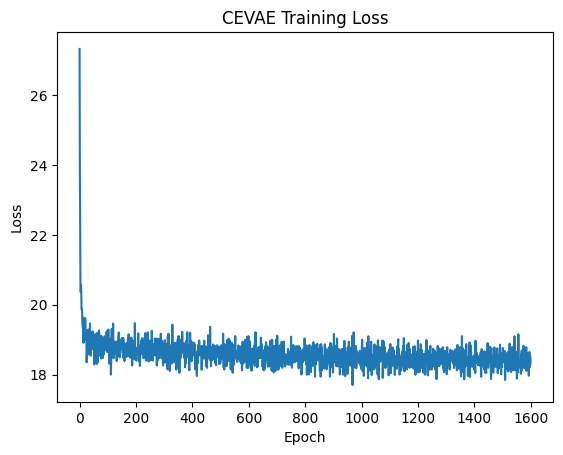

INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.42208


Estimated (test) ATE: 1.4221
True ATE: 1.0008


In [13]:
# before every training run:
pyro.clear_param_store()

cevae = CEVAE(
    feature_dim=length_x,
    latent_dim=1,
    outcome_dist="normal",
    num_layers=5,
    hidden_dim=300
    )

losses = cevae.fit(
    x_train, t_train, y_train,
    num_epochs=100,
    batch_size=100,
    learning_rate=5e-4,
    learning_rate_decay=0.1,
    weight_decay=1e-6
    )

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CEVAE Training Loss')
plt.show()

# Estimate ITEs and ATE
ite = cevae.ite(x_test)
ate = ite.mean().item()

# Compare
print(f"Estimated (test) ATE: {ate:.4f}")
print(f"True ATE: {data['ite'].mean().item():.4f}")

In [14]:
# Save the model
torch.save(cevae, "cevae_model_full.pth")

cevae_loaded = torch.load("cevae_model_full.pth", weights_only=False)

# Assessment

## General function for the experiments

In [2]:
def run_experiment(
    param_grid: dict,
    data_fn: callable,
    model_cls: type,
    metrics_fns: dict,
    data_kwargs: dict,
    model_kwargs: dict,
    fit_kwargs: dict,
    test_size: float = 0.2,
    random_state: int = 0,
):
    """
    Sweeps over one or more parameters (given in param_grid) and returns a DataFrame
    of results.

    param_grid: mapping from "stage__param_name" to list of values.
       e.g. {"data__shuffle_pct": np.linspace(0,1,11),
              "model__latent_dim": [1,2,5]}
    data_fn:        function(**data_kwargs) -> dict with keys "x","t","y","ite"
    model_cls:      class of your model; instantiated as model_cls(**model_kwargs)
    fit_kwargs:     kwargs passed to model.fit(...)
    metrics_fns:    mapping from metric_name -> function(model, x_te, ite_te) -> float

    Returns a pandas DataFrame with one row per combination, columns for each
    swept param plus each metric.
    """
    # 1) build list of all combinations
    keys, values = zip(*param_grid.items())
    combos = [dict(zip(keys, combo)) for combo in itertools.product(*values)]

    records = []
    for combo in combos:
        # prepare stage-specific kwargs
        dk = data_kwargs.copy()
        mk = model_kwargs.copy()
        fk = fit_kwargs.copy()

        # dispatch combo entries into dk/mk/fk
        for full_key, val in combo.items():
            stage, param = full_key.split("__", 1)
            if stage == "data":
                dk[param] = val
            elif stage == "model":
                mk[param] = val
            elif stage == "fit":
                fk[param] = val
            else:
                raise ValueError(f"Unknown stage “{stage}”")

        # run one trial
        data = data_fn(**dk)
        x, t, y, ite = data["x"], data["t"], data["y"], data["ite"]
        x_tr, x_te, t_tr, t_te, y_tr, y_te, ite_tr, ite_te = train_test_split(
            x, t, y, ite, test_size=test_size, random_state=random_state
        )

        pyro.clear_param_store()
        model = model_cls(**mk)
        losses = model.fit(x_tr, t_tr, y_tr, **fk)

        # 4) build result row
        row = dict(combo)
        row["final_elbo"] = losses[-1] 
        for mname, mfn in metrics_fns.items():
            row[mname] = mfn(model, x_te, ite_te)
        records.append(row)

    return pd.DataFrame.from_records(records)

# ---------------------------- metrics definition ---------------------------- #

def rel_ate_error(model, x_te, ite_te):
    est = model.ite(x_te).mean().item()
    true = ite_te.mean().item()
    return abs(est - true) / abs(true)

def nrmse_ite(model, x_te, ite_te):
    pred = model.ite(x_te).cpu().numpy()
    true = ite_te.cpu().numpy()
    rmse = np.sqrt(np.mean((pred - true) ** 2))
    return rmse / true.std()


In [3]:
def plot_experiment_results(results, x_param="data__shuffle_pct"):
    """
    Given a DataFrame `results` where one column is your swept parameter
    (e.g. "data__shuffle_pct") and the others are metrics, this function
    will produce one plot per metric.
    """
    # find all metric columns
    metrics = [c for c in results.columns if c != x_param]

    for metric in metrics:
        plt.figure(figsize=(6, 4))
        plt.plot(results[x_param], results[metric], marker="o")
        plt.xlabel(x_param)
        plt.ylabel(metric)
        plt.title(f"{metric.replace('_',' ').title()} vs {x_param}")
        plt.tight_layout()
        plt.show()

In [6]:
# 1) define your defaults
data_defaults_non_lin = dict(
    n=1000,
    num_proxies=100,
    sigma_x=1.0,
    sigma_y=1.0,
    prior_type="gaussian",
    seed=0,
)

data_defaults_linear = dict(
    n=1000,
    beta=1.0,
    num_proxies=100,
    shuffle_pct=0.0,
    sigma_x=1.0,
    sigma_y=1.0,
    seed=0,
)

model_defaults = dict(
    feature_dim=100,
    latent_dim=1,
    hidden_dim=10,
    num_layers=2,
    outcome_dist="normal",
)

fit_defaults = dict(
    num_epochs=100,
    batch_size=100,
    learning_rate=1e-2,
    weight_decay=0.0,
    log_every=0,
)

metrics = {
    "rel_ate_err": rel_ate_error,
    "nrmse_ite": nrmse_ite,
}


In [ ]:
# set up params to sweep
param_grid = {
    "data__shuffle_pct": np.linspace(0.0, 1.0, 11),
}

# run the experiment
results = run_experiment(
    param_grid,
    data_fn=synthetic_dataset_pyro,
    model_cls=CEVAE,
    metrics_fns=metrics,
    data_kwargs=data_defaults_non_lin,
    model_kwargs=model_defaults,
    fit_kwargs=fit_defaults,
)

print(results)


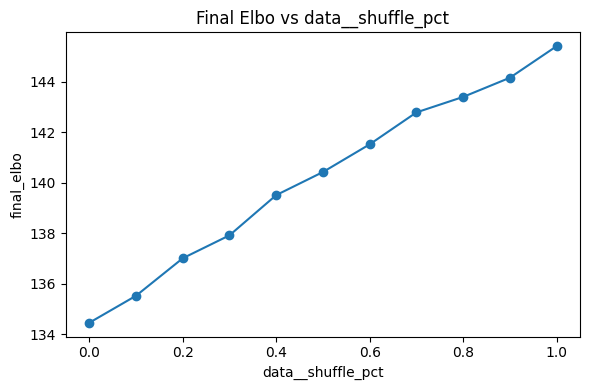

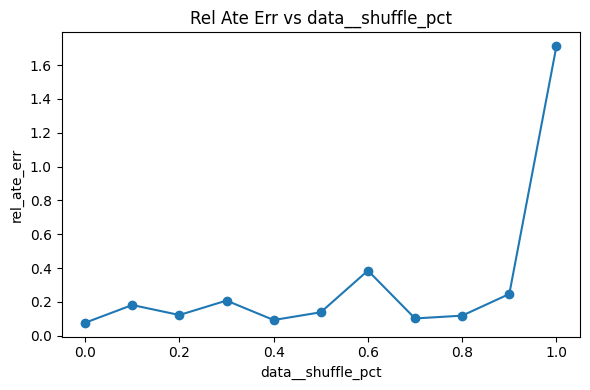

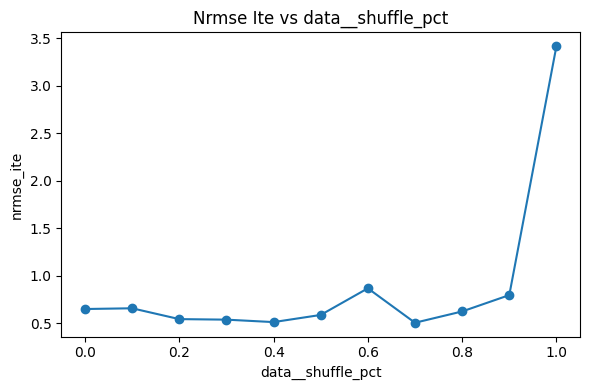

In [8]:

plot_experiment_results(results)


In [7]:
results = run_experiment(
    param_grid   = {"data__shuffle_pct": np.linspace(0, 1, 11)},
    data_fn      = synthetic_dataset_linear,  
    model_cls    = CEVAE,
    metrics_fns  = metrics,                   
    data_kwargs  = data_defaults_linear,      
    model_kwargs = model_defaults,
    fit_kwargs   = fit_defaults,
)

INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.09692
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.09832
/tmp/ipykernel_50723/1223618497.py:81: RuntimeWarning: divide by zero encountered in scalar divide
  return rmse / true.std()
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.13806
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.13781
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.11197
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.11344
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.02102
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.01989
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.94288
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.943122
INFO 	 Training with 8 minibatches per epoch
INF

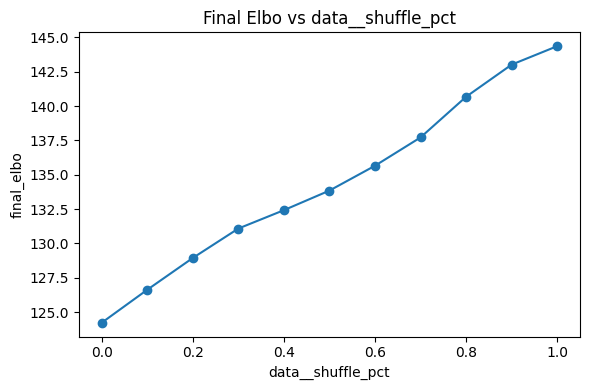

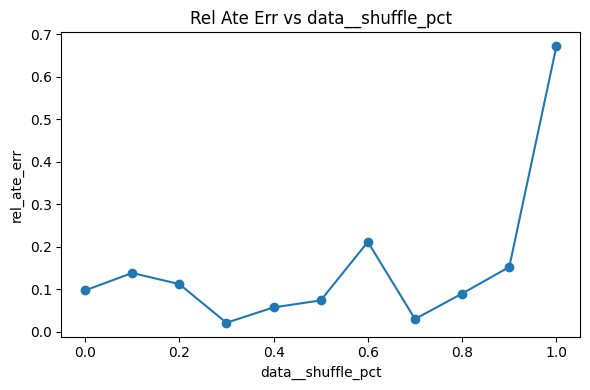

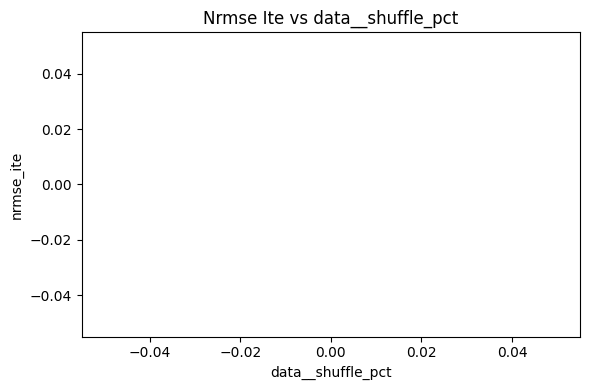

In [8]:
plot_experiment_results(results)

## experiment 1: $n=1000$, error as function of number of proxies

In [15]:
n = 1000
proxy_list = list(range(1, 111, 10))
errors = []

for num_proxies in proxy_list:
    data = synthetic_dataset_pyro(
        n=n,
        num_proxies=num_proxies,
        sigma_x=1.0,
        sigma_y=1.0,
        shuffle_pct=0.0,
        prior_type="gaussian",
        seed=0,
    )
    x, t, y = data["x"], data["t"], data["y"]

    pyro.clear_param_store()
    cevae = CEVAE(
        feature_dim=num_proxies,
        latent_dim=1,
        hidden_dim=10,
        num_layers=2,
        outcome_dist="normal",
    )

    cevae.fit(
        x, t, y,
        num_epochs=100,      # fewer epochs
        batch_size=100,
        learning_rate=1e-2,
        weight_decay=0.0,
        log_every=0
    )

    est_ate = cevae.ite(x).mean().item()
    true_ate = data["ite"].mean().item()
    errors.append(abs(est_ate - true_ate))


INFO 	 Training with 10 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.89303
INFO 	 Training with 10 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.49827
INFO 	 Training with 10 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.40755
INFO 	 Training with 10 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.24454
INFO 	 Training with 10 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.29942
INFO 	 Training with 10 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.10005
INFO 	 Training with 10 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.24584
INFO 	 Training with 10 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.19698
INFO 	 Training with 10 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.21185
INFO 	 Training with 10 minibatches per epoch


## same experiment but train/test split

INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.7566
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.5477
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.39049
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.20761
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.30332
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.15768
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.23384
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.21635
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.23227
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evalu

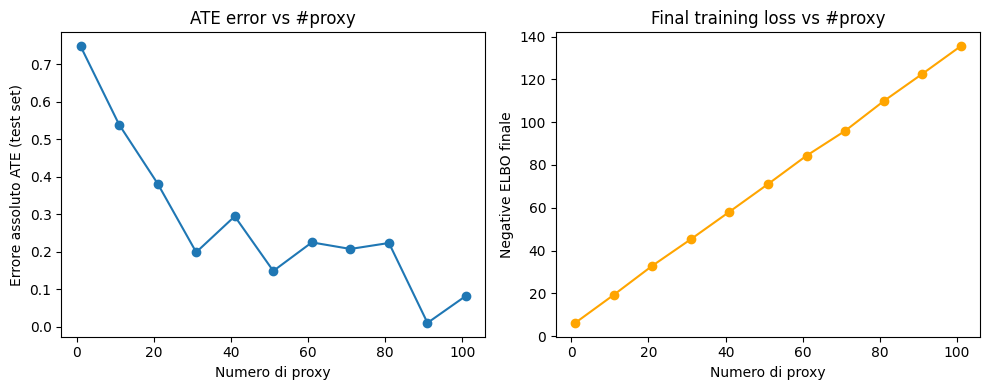

In [16]:
n = 1000
proxy_list = list(range(1, 111, 10))
errors = []
rel_ate_errors = []
nrmse_ites       = []
final_losses = []

for num_proxies in proxy_list:
    # 1) generate
    data = synthetic_dataset_pyro(
        n=n,
        num_proxies=num_proxies,
        sigma_x=1.0,
        sigma_y=1.0,
        shuffle_pct=0.0,
        prior_type="gaussian",
        seed=0,
    )
    x, t, y, ite = data["x"], data["t"], data["y"], data["ite"]

    # 2) split into train/test
    x_train, x_test, t_train, t_test, y_train, y_test, ite_train, ite_test = train_test_split(
        x, t, y, ite, test_size=0.2, random_state=0
    )

    # 3) clear & build model
    pyro.clear_param_store()
    cevae = CEVAE(
        feature_dim=num_proxies,
        latent_dim=1,
        hidden_dim=10,
        num_layers=2,
        outcome_dist="normal",
    )

    # 4) fit on train
    losses= cevae.fit(
        x_train, t_train, y_train,
        num_epochs=100,
        batch_size=100,     # or use x_train.shape[0] for full-batch
        learning_rate=1e-2,
        weight_decay=0.0,
        log_every=0
    )

    # salva l'ultimo valore
    final_losses.append(losses[-1])

    # 5) evaluate ATE on test
    est_ate = cevae.ite(x_test).mean().item()
    true_ate = ite_test.mean().item()
    errors.append(abs(est_ate - true_ate))
    

# 6) plot errore ATE
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(proxy_list, errors, marker='o')
plt.xlabel("Numero di proxy")
plt.ylabel("Errore assoluto ATE (test set)")
plt.title("ATE error vs #proxy")

# 7) plot loss finale
plt.subplot(1,2,2)
plt.plot(proxy_list, final_losses, marker='o', color='orange')
plt.xlabel("Numero di proxy")
plt.ylabel("Negative ELBO finale")
plt.title("Final training loss vs #proxy")

plt.tight_layout()
plt.show()


From this experiment we can see two things:
1. for a fixed number of data ($n=1000$) the performance of the model improves as the number of proxies increase. This make sense: the core idea of the use of VAEs to perform causal inference is that we are able to estimate the latent confounder in the big data regime, *i.e.*, in under the assumption that we have enough proxy variable of it. This is  pretty interestin result since nowadays we are in the big data regine. So given enough proxies we can estimate z better and better.
2. the minimum of the loss increases **linearly** when we increase the number of proxies. Does this make sense? Is the Elbow directly proportional (linearly) in the number of proxies (in the paper called $D_x$)? Yes.
The reconstruction term of $x$ 
$$
\mathbb{E}_q[\log(p(x|z))]
$$
where 

$$
\log(p(x|z))=\sum_{j=1}^{D_x}\log(p(x_j|z))
$$

and $p(x_j|z)\sim\mathcal{N}(\mu,\sigma^2)$, hence:

$$
\log(p(x|z))=\sum_{j=1}^{D_x}\frac{1}{2}[\log(2\pi\sigma^2)+\frac{(x_j-\mu_j(z))^2}{\sigma^2}]
$$

and for fixed $\sigma$ it is increasing with $D_x$

## same but with more metrics

INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.7566
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.76445
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.5477
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.55321
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.39049
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.3937
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.20761
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.20313
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.30332
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.30516
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.15768
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.14246
INFO 	 Traini

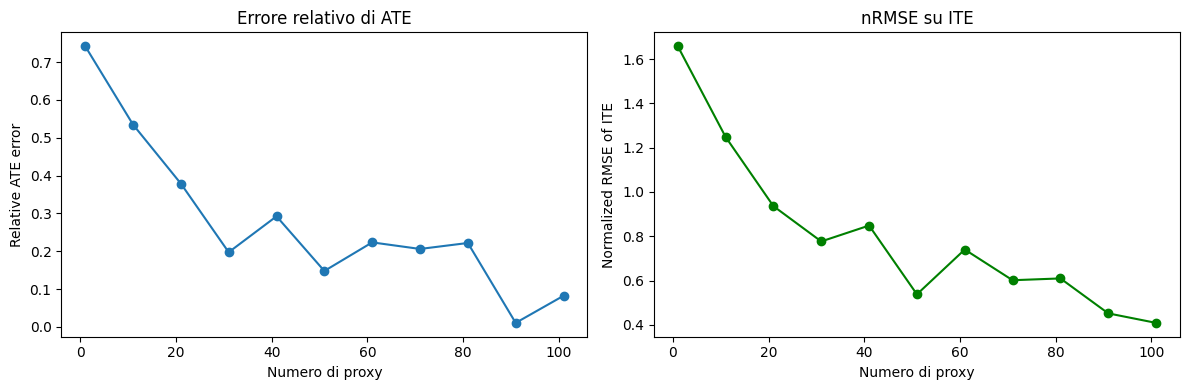

In [17]:
n = 1000
proxy_list = list(range(1, 111, 10))

rel_ate_errors = []
nrmse_ites       = []

for num_proxies in proxy_list:
    data = synthetic_dataset_pyro(
        n=n, num_proxies=num_proxies,
        sigma_x=1.0, sigma_y=1.0,
        shuffle_pct=0.0, prior_type="gaussian",
        seed=0,
    )
    x, t, y, ite = data["x"], data["t"], data["y"], data["ite"]
    x_tr, x_te, t_tr, t_te, y_tr, y_te, ite_tr, ite_te = train_test_split(
        x, t, y, ite, test_size=0.2, random_state=0
    )

    pyro.clear_param_store()
    cevae = CEVAE(
        feature_dim=num_proxies,
        latent_dim=1,
        hidden_dim=10,
        num_layers=2,
        outcome_dist="normal",
    )
    cevae.fit(
        x_tr, t_tr, y_tr,
        num_epochs=100,
        batch_size=100,
        learning_rate=1e-2,
        weight_decay=0.0,
        log_every=0
    )

    # ATE error (relative)
    est_ate  = cevae.ite(x_te).mean().item()
    true_ate = ite_te.mean().item()
    rel_ate_errors.append(abs(est_ate - true_ate) / abs(true_ate))

    # ITE RMSE & normalized RMSE
    ite_pred = cevae.ite(x_te).cpu().numpy()
    ite_true = ite_te.cpu().numpy()
    rmse      = np.sqrt(np.mean((ite_pred - ite_true)**2))
    nrmse     = rmse / ite_true.std()
    nrmse_ites.append(nrmse)

# Plots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(proxy_list, rel_ate_errors, marker='o')
axes[0].set_xlabel("Numero di proxy")
axes[0].set_ylabel("Relative ATE error")
axes[0].set_title("Errore relativo di ATE")

axes[1].plot(proxy_list, nrmse_ites, marker='o', color='green')
axes[1].set_xlabel("Numero di proxy")
axes[1].set_ylabel("Normalized RMSE of ITE")
axes[1].set_title("nRMSE su ITE")

plt.tight_layout()
plt.show()


## Shuffling the proxies: less-informative proxies 

INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.08546
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.08475
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.19123
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.19274
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.1316
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.12932
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.2177
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.20786
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.10178
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.1036
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.869018
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.869313
INFO 	 Trai

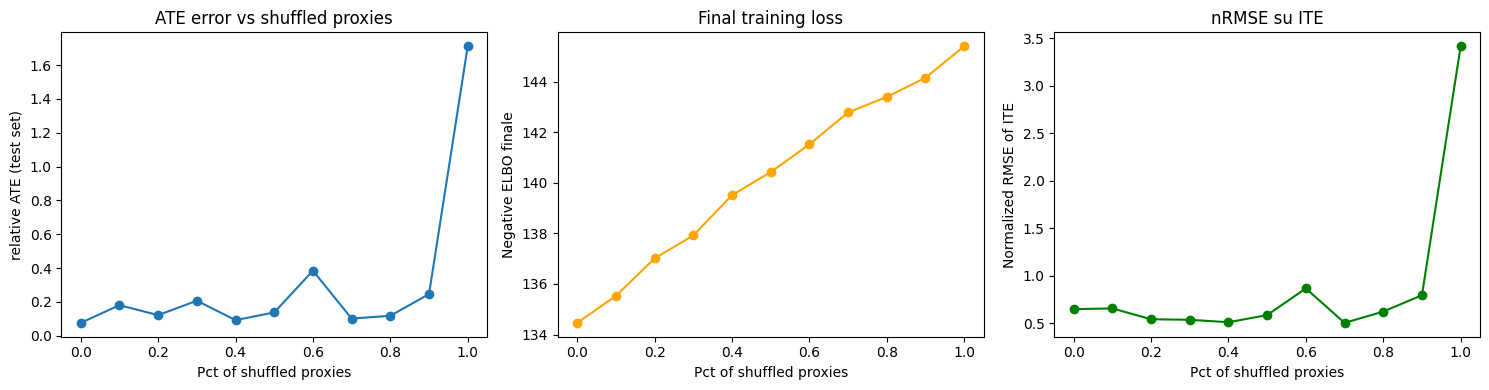

In [18]:
n = 1000
shuffle_list = np.linspace(0.0, 1.0, 11)  # from 0% to 100% shuffled proxies
num_proxies = 100

rel_ate_errors = []
nrmse_ites       = []
final_losses = []

for s in shuffle_list:
    # 1) generate
    data = synthetic_dataset_pyro(
        n=n,
        num_proxies=num_proxies,
        sigma_x=1.0,
        sigma_y=1.0,
        shuffle_pct=s,
        prior_type="gaussian",
        seed=0,
    )
    x, t, y, ite = data["x"], data["t"], data["y"], data["ite"]
    x_tr, x_te, t_tr, t_te, y_tr, y_te, ite_tr, ite_te = train_test_split(
        x, t, y, ite, test_size=0.2, random_state=0
    )

    # 3) clear & build model
    pyro.clear_param_store()
    cevae = CEVAE(
        feature_dim=num_proxies,
        latent_dim=1,
        hidden_dim=10,
        num_layers=2,
        outcome_dist="normal",
    )

    # 4) fit on train
    losses= cevae.fit(
        x_tr, t_tr, y_tr,
        num_epochs=100,
        batch_size=100,     # or use x_train.shape[0] for full-batch
        learning_rate=1e-2,
        weight_decay=0.0,
        log_every=0
    )

    # salva l'ultimo valore
    final_losses.append(losses[-1])

    # 5) evaluate ATE on test
    est_ate  = cevae.ite(x_te).mean().item()
    true_ate = ite_te.mean().item()
    rel_ate_errors.append(abs(est_ate - true_ate) / abs(true_ate))

    # ITE RMSE & normalized RMSE
    ite_pred = cevae.ite(x_te).cpu().numpy()
    ite_true = ite_te.cpu().numpy()
    rmse      = np.sqrt(np.mean((ite_pred - ite_true)**2))
    nrmse     = rmse / ite_true.std()
    nrmse_ites.append(nrmse)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1) ATE absolute error
axes[0].plot(shuffle_list, rel_ate_errors, marker='o')
axes[0].set_xlabel("Pct of shuffled proxies")
axes[0].set_ylabel("relative ATE (test set)")
axes[0].set_title("ATE error vs shuffled proxies")

# 2) Final training loss
axes[1].plot(shuffle_list, final_losses, marker='o', color='orange')
axes[1].set_xlabel("Pct of shuffled proxies")
axes[1].set_ylabel("Negative ELBO finale")
axes[1].set_title("Final training loss")

# 3) Normalized RMSE of ITE
axes[2].plot(shuffle_list, nrmse_ites, marker='o', color='green')
axes[2].set_xlabel("Pct of shuffled proxies")
axes[2].set_ylabel("Normalized RMSE of ITE")
axes[2].set_title("nRMSE su ITE")

plt.tight_layout()
plt.show()

this is very interesting: given enough proxies it is still able to understand the information! The problem could be in the shuffle operation, that is noth truly uninformative.

### same experiment: reverse order of decorrelation

INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 2.73503
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 2.73617
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.25709
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.25391
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.12784
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.12403
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.11111
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.1138
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.39665
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.40061
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.869018
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.869313
INFO 	 Tr

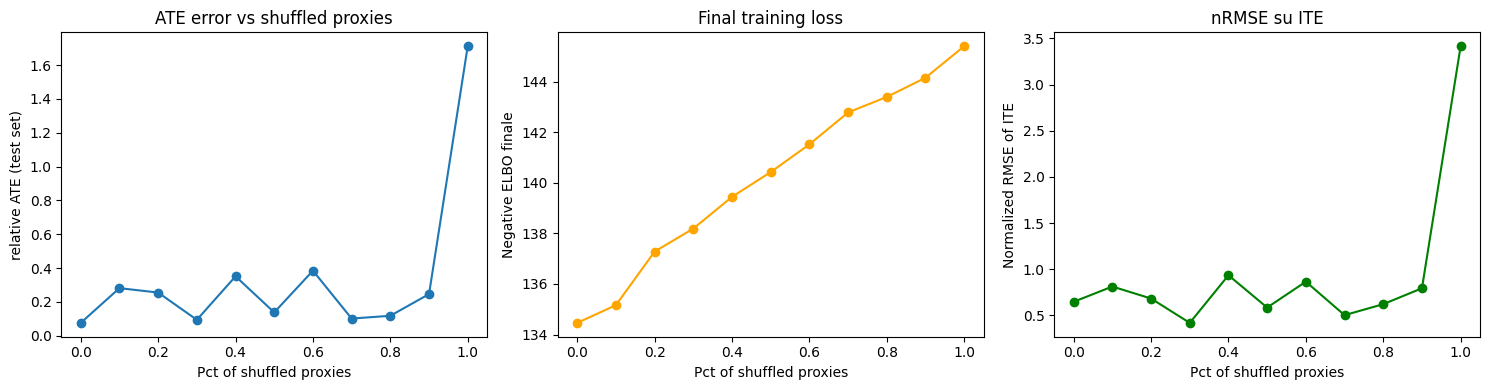

In [19]:
n = 1000
shuffle_list = np.linspace(1.0, 0.0, 11)  # from 0% to 100% shuffled proxies
num_proxies = 100

rel_ate_errors = []
nrmse_ites       = []
final_losses = []

for s in shuffle_list:
    # 1) generate
    data = synthetic_dataset_pyro(
        n=n,
        num_proxies=num_proxies,
        sigma_x=1.0,
        sigma_y=1.0,
        shuffle_pct=s,
        prior_type="gaussian",
        seed=0,
    )
    x, t, y, ite = data["x"], data["t"], data["y"], data["ite"]
    x_tr, x_te, t_tr, t_te, y_tr, y_te, ite_tr, ite_te = train_test_split(
        x, t, y, ite, test_size=0.2, random_state=0
    )

    # 3) clear & build model
    pyro.clear_param_store()
    cevae = CEVAE(
        feature_dim=num_proxies,
        latent_dim=1,
        hidden_dim=10,
        num_layers=2,
        outcome_dist="normal",
    )

    # 4) fit on train
    losses= cevae.fit(
        x_tr, t_tr, y_tr,
        num_epochs=100,
        batch_size=100,     # or use x_train.shape[0] for full-batch
        learning_rate=1e-2,
        weight_decay=0.0,
        log_every=0
    )

    # salva l'ultimo valore
    final_losses.append(losses[-1])

    # 5) evaluate ATE on test
    est_ate  = cevae.ite(x_te).mean().item()
    true_ate = ite_te.mean().item()
    rel_ate_errors.append(abs(est_ate - true_ate) / abs(true_ate))

    # ITE RMSE & normalized RMSE
    ite_pred = cevae.ite(x_te).cpu().numpy()
    ite_true = ite_te.cpu().numpy()
    rmse      = np.sqrt(np.mean((ite_pred - ite_true)**2))
    nrmse     = rmse / ite_true.std()
    nrmse_ites.append(nrmse)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1) ATE absolute error
axes[0].plot(shuffle_list, rel_ate_errors, marker='o')
axes[0].set_xlabel("Pct of shuffled proxies")
axes[0].set_ylabel("relative ATE (test set)")
axes[0].set_title("ATE error vs shuffled proxies")

# 2) Final training loss
axes[1].plot(shuffle_list, final_losses, marker='o', color='orange')
axes[1].set_xlabel("Pct of shuffled proxies")
axes[1].set_ylabel("Negative ELBO finale")
axes[1].set_title("Final training loss")

# 3) Normalized RMSE of ITE
axes[2].plot(shuffle_list, nrmse_ites, marker='o', color='green')
axes[2].set_xlabel("Pct of shuffled proxies")
axes[2].set_ylabel("Normalized RMSE of ITE")
axes[2].set_title("nRMSE su ITE")

plt.tight_layout()
plt.show()

same result: the hypothesis wat some memory issue with the parameters. the VAE is able to find correlations (given enough data) even with shuffled data!

## Robustness over $\sigma_X$

In [20]:
n = 1000
sigma_list = np.linspace(1.0, 5.0, 10)  # from 0% to 100% shuffled proxies
num_proxies = 100

rel_ate_errors = []
nrmse_ites       = []
final_losses = []

for s in sigma_list:
    # 1) generate
    data = synthetic_dataset_pyro(
        n=n,
        num_proxies=num_proxies,
        sigma_x=s,
        sigma_y=1.0,
        shuffle_pct=0.0,
        prior_type="gaussian",
        seed=0,
    )
    x, t, y, ite = data["x"], data["t"], data["y"], data["ite"]
    x_tr, x_te, t_tr, t_te, y_tr, y_te, ite_tr, ite_te = train_test_split(
        x, t, y, ite, test_size=0.2, random_state=0
    )

    # 3) clear & build model
    pyro.clear_param_store()
    cevae = CEVAE(
        feature_dim=num_proxies,
        latent_dim=1,
        hidden_dim=10,
        num_layers=2,
        outcome_dist="normal",
    )

    # 4) fit on train
    losses= cevae.fit(
        x_tr, t_tr, y_tr,
        num_epochs=100,
        batch_size=100,     # or use x_train.shape[0] for full-batch
        learning_rate=1e-2,
        weight_decay=0.0,
        log_every=0
    )

    # salva l'ultimo valore
    final_losses.append(losses[-1])

    # 5) evaluate ATE on test
    est_ate  = cevae.ite(x_te).mean().item()
    true_ate = ite_te.mean().item()
    rel_ate_errors.append(abs(est_ate - true_ate) / abs(true_ate))

    # ITE RMSE & normalized RMSE
    ite_pred = cevae.ite(x_te).cpu().numpy()
    ite_true = ite_te.cpu().numpy()
    rmse      = np.sqrt(np.mean((ite_pred - ite_true)**2))
    nrmse     = rmse / ite_true.std()
    nrmse_ites.append(nrmse)



INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.08546
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.08475
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.13602
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.13702
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.22111
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.22418
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.29472
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.30393
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.38087
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.38599
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.48258
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.48827
INFO 	 Tra

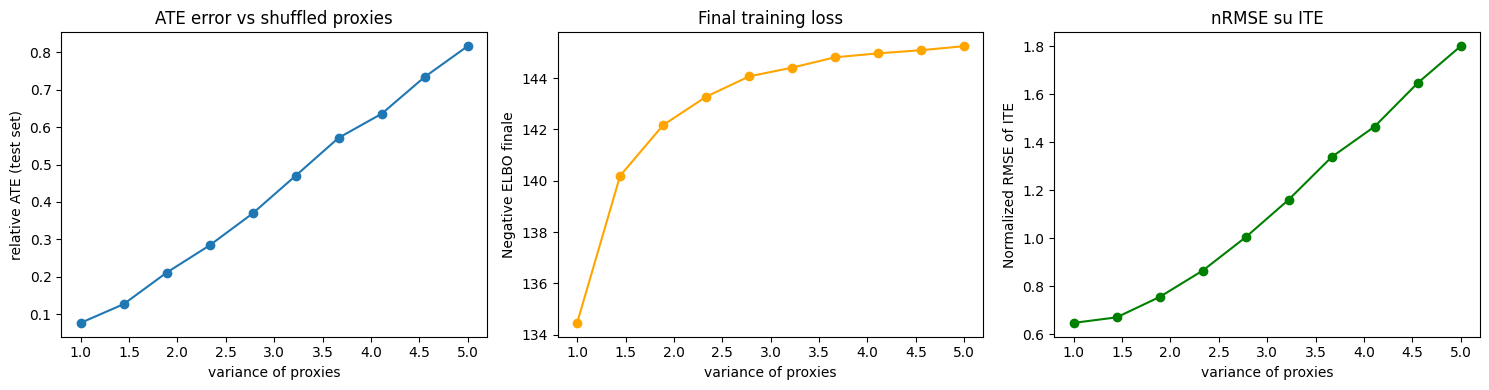

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
# 1) ATE absolute error
axes[0].plot(sigma_list, rel_ate_errors, marker='o')
axes[0].set_xlabel("variance of proxies")
axes[0].set_ylabel("relative ATE (test set)")
axes[0].set_title("ATE error vs shuffled proxies")

# 2) Final training loss
axes[1].plot(sigma_list, final_losses, marker='o', color='orange')
axes[1].set_xlabel("variance of proxies")
axes[1].set_ylabel("Negative ELBO finale")
axes[1].set_title("Final training loss")

# 3) Normalized RMSE of ITE
axes[2].plot(sigma_list, nrmse_ites, marker='o', color='green')
axes[2].set_xlabel("variance of proxies")
axes[2].set_ylabel("Normalized RMSE of ITE")
axes[2].set_title("nRMSE su ITE")

plt.tight_layout()
plt.show()

## Robustness over prior misspecification

In [22]:
n = 1000
proxy_list = np.linspace(1, 100, 10)

rel_ate_errors = []
nrmse_ites       = []
final_losses = []

for num_proxies in proxy_list:
    num_proxies = int(num_proxies)  # ensure integer
    # 1) generate
    data = synthetic_dataset_pyro(
        n=n,
        num_proxies=num_proxies,
        sigma_x=1.0,
        sigma_y=1.0,
        shuffle_pct=0.0,
        prior_type="bimodal",
        seed=0,
    )
    x, t, y, ite = data["x"], data["t"], data["y"], data["ite"]
    x_tr, x_te, t_tr, t_te, y_tr, y_te, ite_tr, ite_te = train_test_split(
        x, t, y, ite, test_size=0.2, random_state=0
    )

    # 3) clear & build model
    pyro.clear_param_store()
    cevae = CEVAE(
        feature_dim=num_proxies,
        latent_dim=1,
        hidden_dim=10,
        num_layers=2,
        outcome_dist="normal",
    )

    # 4) fit on train
    losses= cevae.fit(
        x_tr, t_tr, y_tr,
        num_epochs=100,
        batch_size=100,     # or use x_train.shape[0] for full-batch
        learning_rate=1e-2,
        weight_decay=0.0,
        log_every=0
    )

    # salva l'ultimo valore
    final_losses.append(losses[-1])

    # 5) evaluate ATE on test
    est_ate  = cevae.ite(x_te).mean().item()
    true_ate = ite_te.mean().item()
    rel_ate_errors.append(abs(est_ate - true_ate) / abs(true_ate))

    # ITE RMSE & normalized RMSE
    ite_pred = cevae.ite(x_te).cpu().numpy()
    ite_true = ite_te.cpu().numpy()
    rmse      = np.sqrt(np.mean((ite_pred - ite_true)**2))
    nrmse     = rmse / ite_true.std()
    nrmse_ites.append(nrmse)



INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 4.42184
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 4.43202
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.98667
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 2.0195
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.61594
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.59518
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.24647
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.22025
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.04598
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 1.03785
INFO 	 Training with 8 minibatches per epoch
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.820168
INFO 	 Evaluating 1 minibatches
DEBUG 	 batch ate = 0.827237
INFO 	 Tr

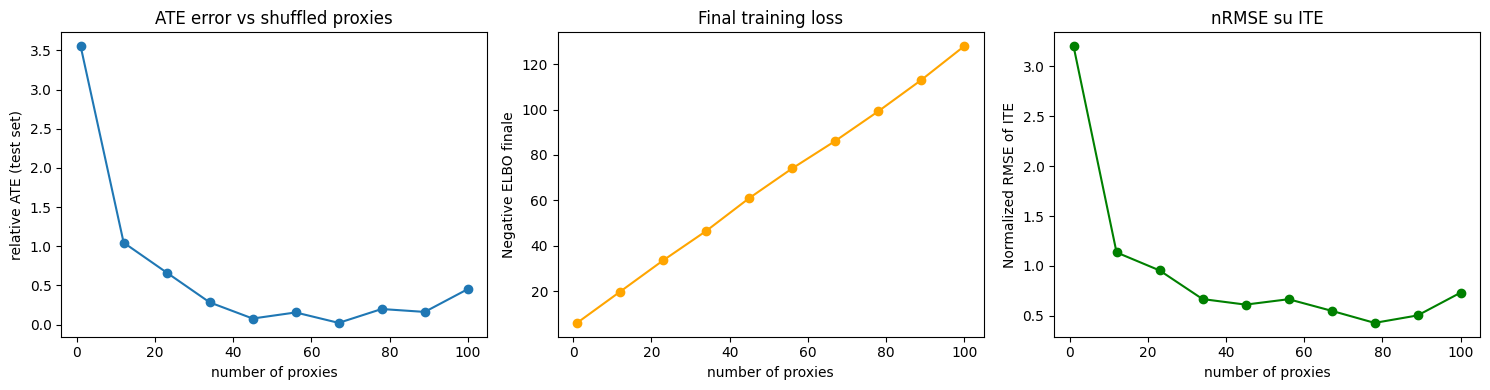

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1) ATE absolute error
axes[0].plot(proxy_list, rel_ate_errors, marker='o')
axes[0].set_xlabel("number of proxies")
axes[0].set_ylabel("relative ATE (test set)")
axes[0].set_title("ATE error vs shuffled proxies")

# 2) Final training loss
axes[1].plot(proxy_list, final_losses, marker='o', color='orange')
axes[1].set_xlabel("number of proxies")
axes[1].set_ylabel("Negative ELBO finale")
axes[1].set_title("Final training loss")

# 3) Normalized RMSE of ITE
axes[2].plot(proxy_list, nrmse_ites, marker='o', color='green')
axes[2].set_xlabel("number of proxies")
axes[2].set_ylabel("Normalized RMSE of ITE")
axes[2].set_title("nRMSE su ITE")

plt.tight_layout()
plt.show()